## How to run the lstchain_dl1ab.py script (example using Monte Carlo)


It is covenient to define an environment variable LSTCHAIN pointing to the lstchain directory. For instance, if you are using one a standard installation in the cp* machines:

```
export LSTCHAIN=/fefs/aswg/software/conda/envs/lstchain-v0.8.2/lib/python3.8/site-packages/lstchain
```

<br>
Now check the help of the script:

```
$ python $LSTCHAIN/scripts/lstchain_dl1ab.py -h
usage: lstchain_dl1ab.py [-h] --input-file INPUT_FILE --output-file
                         OUTPUT_FILE [--config CONFIG_FILE]
                         [--no-image NOIMAGE]
                         [--pedestal-cleaning PEDESTAL_CLEANING]

Recompute DL1b parameters from a DL1a file

optional arguments:
  -h, --help            show this help message and exit
  --input-file INPUT_FILE, -f INPUT_FILE
                        path to the DL1a file
  --output-file OUTPUT_FILE, -o OUTPUT_FILE
                        key for the table of new parameters
  --config CONFIG_FILE, -c CONFIG_FILE
                        Path to a configuration file. If none is given, a
                        standard configuration is applied
  --no-image NOIMAGE    Boolean. True to remove the images in output file
  --pedestal-cleaning PEDESTAL_CLEANING
                        Boolean. True to use pedestal cleaning
```

#### Notes:
- the script recalculates image parameters (DL1b) using calibrated images (DL1a) found in the input file, and applying whatever image cleaning settings are provided through the configuration file. Therefore the input file must contain the DL1a information, that is, the "images" table.
- when the no-image option is set to False (which is the default) the "images" table of the input file is copied to the output file, except in case the image_modifier option is activated via the config file (see below)
- the pedestal-cleaning option (set to false by default) is only for processing real data. It increases the picture cleaning threshold for noisy pixels (e.g. those illuminated by stars) to avoid spurious signals.


#### Suggested input file (point-like gammas, 0.4 deg wobble offset):

`/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/gamma/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/off0.4deg/testing/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5`

The input file (30M) is also copied in `/fefs/aswg/workspace/analysis-school-2022/DL1ab/` as part of the school's dataset, in case you want to do the exercises in your own computer. Just set output-file to a file under e.g. your own directory `/fefs/aswg/workspace/name.surname/...`


If no configuration file is given, the standard lstchain configuration file lstchain_standard_config.json is used. For the test you can use the example configuration file `$LSTCHAIN/data/lstchain_dl1ab_tune_MC_to_Crab_config.json` (copy it somewhere else if you want to play with the settings). Under "tailcut" and "dynamic cleaning" you can set the parameters for the image cleaning. The "image_modifier" section is discussed below.

```
{
  "image_modifier": {
    "increase_nsb": true,
    "extra_noise_in_dim_pixels": 1.2,
    "extra_bias_in_dim_pixels": 0.5,
    "transition_charge": 8,
    "extra_noise_in_bright_pixels": 1.2,
    "increase_psf": true,
    "smeared_light_fraction": 0.125
  },

  "tailcut": {
    "picture_thresh":8,
    "boundary_thresh":4,
    "keep_isolated_pixels":false,
    "min_number_picture_neighbors":2,
    "use_only_main_island":false,
    "delta_time": 2
  },

  "dynamic_cleaning": {
    "apply": true,
    "threshold": 267,
    "fraction_cleaning_intensity": 0.03
  }
}

```

#### image__modifier settings:
These are intended for fine-tuning MC simulations to a given set of real data, in terms of the diffuse NSB noise level in the pixels, and of the optical point-spread function of the telescope. In this way we can adapt a given MC set to different observations, without having to re-simulate the events, or even re-calibrate them. The settings in the json file above tune our current MC to observations of the Crab nebula **. We recommend to leave those settings unchanged for the test.

Whenever increase_psf and/or increase_nsb are true, the images are modified before the cleaning step (by adding random noise to each pixel, and/or spreading the charge to simulate a worse PSF). Currently any of these two options automatically switches off the saving of the DL1a ("images" table) to the output of lstchain_dl1ab.py


<br>
<br>
** The NSB settings for a different field can be obtained with the script `$LSTCHAIN/lstchain_tune_nsb.py`, but that is not part of this exercise; the production of the adequate MC for each set of real data will eventually be automatized.

#### Example of lstchain_dl1ab.py call (assuming you are in the desired output directory):

```
python $LSTCHAIN/scripts/lstchain_dl1ab.py -f /fefs/aswg/workspace/analysis-school-2022/DL1ab/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5 -o ./gamma_dl1.h5 -c $LSTCHAIN/data/lstchain_dl1ab_tune_MC_to_Crab_config.json
```

You will get some text output reporting the cleaning and other settings, a number of harmless messages of the "NaturalNameWarning" type, and finally the progress bars indicating successful completion of the execution. The execution for a single DL1 MC file is very fast, but if you are running in the IT cluster you can also try to put the command in a bash script and submit it using slurm.


You may want to play with the cleaning settings and compare the output image parameters (width, length...). The rest of the notebook explains how to access the DL1b data in the DL1 files.

## Accessing the contents of the DL1 files

In [36]:
import glob

from ctapipe.io import read_table
from ctapipe.instrument import SubarrayDescription

from astropy.table import vstack, Table
from lstchain.io.io import dl1_params_lstcam_key
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib inline

In [5]:
# You can set here any DL1 file, e.g. the one you have created with the lstchain_dl1ab.py script:

dl1_file = "/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/gamma/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/off0.4deg/testing/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5"

In [6]:
# Where the image parameters (DL1b) are stored in the hdf5 files:
print(dl1_params_lstcam_key)

/dl1/event/telescope/parameters/LST_LSTCam


In [7]:
# Read a single file (the first in the list):
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)

In [8]:
# Check column names:
print(dl1_parameters.columns)

<TableColumns names=('obs_id','event_id','intensity','log_intensity','x','y','r','phi','length','length_uncertainty','width','width_uncertainty','psi','skewness','kurtosis','time_gradient','intercept','leakage_intensity_width_1','leakage_intensity_width_2','leakage_pixels_width_1','leakage_pixels_width_2','n_pixels','concentration_cog','concentration_core','concentration_pixel','n_islands','alt_tel','az_tel','calibration_id','mc_energy','log_mc_energy','mc_alt','mc_az','mc_core_x','mc_core_y','mc_h_first_int','mc_type','mc_az_tel','mc_alt_tel','mc_x_max','mc_core_distance','wl','tel_id','tel_pos_x','tel_pos_y','tel_pos_z','trigger_type','trigger_time','event_type','disp_dx','disp_dy','disp_norm','disp_angle','disp_sign','src_x','src_y')>


Description of parameters in\
https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

Notes: 
- these DL1 files are provisional and LST-specific. Eventually we will use the agreed DL1 model already implemented in ctapipe:\
    https://cta-observatory.github.io/ctapipe/data_models/dl1.html#dl1-data-model


- the table contains nans for parameters which could not be calculated for whatever reason (e.g. no pixels survived cleaning)


- there are some parameters which do not change event-wise, yet they are written in the events table for convenience (tel_id, tel_pos_x, y, z)


- there is also redundant information: in MC files mc_alt_tel, mc_az_tel are identical to alt_tel, az_tel. Energy (in MC) and intensity appear also in logarithmic form.


- mc_type (primary type, in eventio convention): 0 (gamma), 1(e-), 2(mu-), 100*A+Z for nucleons and nuclei, negative for antimatter


- Some parameters don't have their units in the table (if not mentioned below, they are adimensional):
 - intensity: photoelectrons  (log_intensity is just log10 of that)
 - intercept: ns (it is the fitted time value at the image charge COG)
 - time_gradient: ns / deg (slope of the linear time fit along the majior image axis)
 - trigger_time is a unix time in seconds - for simulations it is just the event sim_telarray simulation time, so it has no physical meaning.

 Only for MC:
 - disp_dx, disp_dy, disp_norm: meters. Note: these are *not* reconstructed values, but true ones (calculated with the true event direction) for the purpose of training the direction reconstruction
 - disp_angle: radians (-pi/2 to pi/2) (same as above, this is the angle between image axis and the line from the image c.o.g. to the true event direction) 
 - src_x src_y: meters. True event direction on the camera.



In [14]:
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,TeV,,rad,rad,m,m,m,,rad,rad,g / cm2,m,,,m,m,m,,,,,,,,,,
int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float64,int64,float32,float32,float32,float32,float32,float32,float32
10,203,962.8705058097839,2.9835678838080453,0.3766974602643858,0.26971417149196647,0.4632998066837891,0.6213815773923851,0.24815977452129712,0.004030397377545174,0.0619686899171285,0.0017828682792850746,1.0450031096906351,0.3056190562506361,2.0159104053672605,-0.21659176719269446,13.64311892205307,0.0,0.0,0.0,0.0,33,0.20039127824167388,0.32881654974163843,0.1100011336830042,1,1.2147492,3.1415927,-1,0.15828366577625275,-0.8005639002308581,1.2217304706573486,3.1415927410125732,8.300270080566406,35.978363037109375,32226.966796875,0,3.1415927,1.2147492,211.7142791748047,118.44808958008554,0.24971287162339975,1,-70.93,-52.07,43.0,32,1606641878.637238,32,-0.18122113,-0.26971418,0.32494128,0.9791789,-1.0,0.19547632,0.0
10,305,149.3123745918274,2.1740958023281083,0.35931261696823574,0.3472054902547814,0.4996570915894472,0.7682635115076883,0.08101828811444416,0.003343657773299832,0.04419573569473079,0.001970080716869115,0.9889772048497784,0.19293724555377859,2.017261789838703,10.935135179831597,12.197618646094819,0.0,0.0,0.0,0.0,7,0.6043930052285348,0.2320471214029143,0.2814084832200045,1,1.2147492,3.1415927,-1,0.019269723445177078,-1.715124518198486,1.2217304706573486,3.1415927410125732,-3.2260520458221436,65.57146453857422,13098.6416015625,0,3.1415927,1.2147492,300.0,135.73260005202582,0.5455032033298597,1,-70.93,-52.07,43.0,32,1606641881.287831,32,-0.16383629,-0.3472055,0.38391924,1.1299039,-1.0,0.19547632,0.0
10,807,72.09015560150146,1.8578759629184929,0.2878696468924734,0.1189431495081443,0.3114745678493095,0.39182002688315043,0.056328301320089445,0.0036427412108808537,0.04793818901165001,0.005123616118763505,1.3574230113168178,0.06372908224720068,2.205976942850693,0.5132910904181358,11.710806029052996,0.0,0.0,0.0,0.0,5,0.7373802894266321,0.5453376042787169,0.5453376042787169,1,1.2147492,3.1415927,-1,0.02786845527589321,-1.5548871031829294,1.2217304706573486,3.1415927410125732,5.178720474243164,37.719139099121094,25513.671875,0,3.1415927,1.2147492,173.3333282470703,117.70567880963914,0.8510497900378348,1,-70.93,-52.07,43.0,32,1606641883.221573,32,-0.092393324,-0.11894315,0.15061209,0.91037166,-1.0,0.19547632,0.0
10,1305,96.84340810775757,1.9860700647055518,0.1317722835591362,-0.7763373434297733,0.7874411759096595,-1.402662905469697,0.11424273081764584,0.0053127722732090165,0.059980675645949375,0.0044843771686004725,1.4454657239802742,0.3264290962287411,1.837749461391416,-21.283126954978272,12.778992947743582,0.0,0.0,0.0,0.0,8,0.3180340709627385,0.4982243143167628,0.1871197374108231,1,1.2147492,3.1415927,-1,0.4249720871448517,-0.3716395941780785,1.2217304706573486,3.1415927410125732,-89.23172760009766,-393.1084899902344,29089.869140625,0,3.1415927,1.2147492,211.81817626953125,341.5292155657408,0.5250283778815694,1,-70.93,-52.07,43.0,32,1606641886.153733,32,0.06370404,0.7763373,0.77894664,1.4889226,1

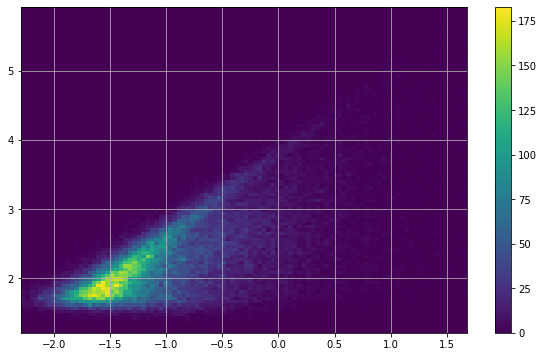

In [59]:
# Simple example plot

mask = dl1_parameters['intensity'] > 0  # successfully cleaned & parametrized images

plt.figure(figsize=(10,6))
plt.hist2d(dl1_parameters['log_mc_energy'][mask], 
           np.log10(dl1_parameters['intensity'][mask]), bins=(100,100))
plt.grid()
plt.colorbar()
plt.show()


In [15]:
# If you need to work with more statistics, you can create a table with many input files.
# glob allows to use wildcards. Example with MC gamma files:
dl1_files = glob.glob("/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/gamma/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/off0.4deg/testing/dl1_gamma_20deg_180deg_run??___*.h5") 

# example proton files:
# dl1_files = glob.glob("/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/testing/dl1_proton_20deg_180deg_run1??___*.h5") 

dl1_files.sort()

# Create empty table for DL1 parameters ()
dl1_parameters = Table()

for file in dl1_files:
    dl1_parameters = vstack([dl1_parameters,
                             read_table(file, dl1_params_lstcam_key)])
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,TeV,,rad,rad,m,m,m,,rad,rad,g / cm2,m,,,m,m,m,,,,,,,,,,
int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float64,int64,float32,float32,float32,float32,float32,float32,float32
10,203,962.8705058097839,2.9835678838080453,0.3766974602643858,0.26971417149196647,0.4632998066837891,0.6213815773923851,0.24815977452129712,0.004030397377545174,0.0619686899171285,0.0017828682792850746,1.0450031096906351,0.3056190562506361,2.0159104053672605,-0.21659176719269446,13.64311892205307,0.0,0.0,0.0,0.0,33,0.20039127824167388,0.32881654974163843,0.1100011336830042,1,1.2147492,3.1415927,-1,0.15828366577625275,-0.8005639002308581,1.2217304706573486,3.1415927410125732,8.300270080566406,35.978363037109375,32226.966796875,0,3.1415927,1.2147492,211.7142791748047,118.44808958008554,0.24971287162339975,1,-70.93,-52.07,43.0,32,1606641878.637238,32,-0.18122113,-0.26971418,0.32494128,0.9791789,-1.0,0.19547632,0.0
10,305,149.3123745918274,2.1740958023281083,0.35931261696823574,0.3472054902547814,0.4996570915894472,0.7682635115076883,0.08101828811444416,0.003343657773299832,0.04419573569473079,0.001970080716869115,0.9889772048497784,0.19293724555377859,2.017261789838703,10.935135179831597,12.197618646094819,0.0,0.0,0.0,0.0,7,0.6043930052285348,0.2320471214029143,0.2814084832200045,1,1.2147492,3.1415927,-1,0.019269723445177078,-1.715124518198486,1.2217304706573486,3.1415927410125732,-3.2260520458221436,65.57146453857422,13098.6416015625,0,3.1415927,1.2147492,300.0,135.73260005202582,0.5455032033298597,1,-70.93,-52.07,43.0,32,1606641881.287831,32,-0.16383629,-0.3472055,0.38391924,1.1299039,-1.0,0.19547632,0.0
10,807,72.09015560150146,1.8578759629184929,0.2878696468924734,0.1189431495081443,0.3114745678493095,0.39182002688315043,0.056328301320089445,0.0036427412108808537,0.04793818901165001,0.005123616118763505,1.3574230113168178,0.06372908224720068,2.205976942850693,0.5132910904181358,11.710806029052996,0.0,0.0,0.0,0.0,5,0.7373802894266321,0.5453376042787169,0.5453376042787169,1,1.2147492,3.1415927,-1,0.02786845527589321,-1.5548871031829294,1.2217304706573486,3.1415927410125732,5.178720474243164,37.719139099121094,25513.671875,0,3.1415927,1.2147492,173.3333282470703,117.70567880963914,0.8510497900378348,1,-70.93,-52.07,43.0,32,1606641883.221573,32,-0.092393324,-0.11894315,0.15061209,0.91037166,-1.0,0.19547632,0.0
10,1305,96.84340810775757,1.9860700647055518,0.1317722835591362,-0.7763373434297733,0.7874411759096595,-1.402662905469697,0.11424273081764584,0.0053127722732090165,0.059980675645949375,0.0044843771686004725,1.4454657239802742,0.3264290962287411,1.837749461391416,-21.283126954978272,12.778992947743582,0.0,0.0,0.0,0.0,8,0.3180340709627385,0.4982243143167628,0.1871197374108231,1,1.2147492,3.1415927,-1,0.4249720871448517,-0.3716395941780785,1.2217304706573486,3.1415927410125732,-89.23172760009766,-393.1084899902344,29089.869140625,0,3.1415927,1.2147492,211.81817626953125,341.5292155657408,0.5250283778815694,1,-70.93,-52.07,43.0,32,1606641886.153733,32,0.06370404,0.7763373,0.77894664,1.4889226,1

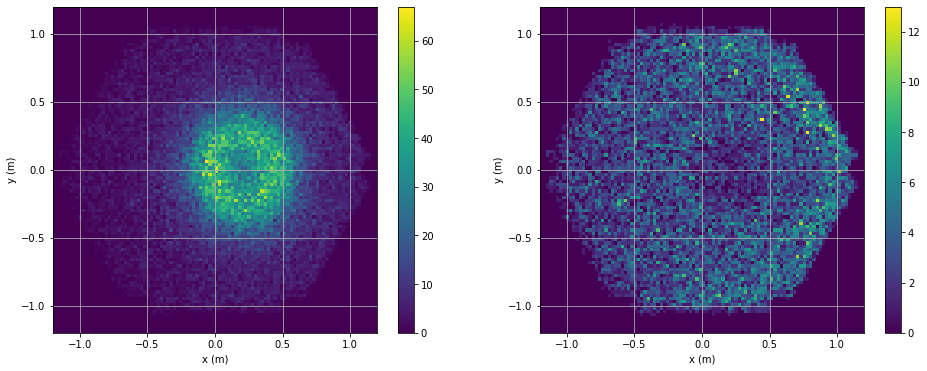

In [35]:
# Some example plots:
# (Note that by setting the range of the axes you don't have to explicitly cut out nans)

fig = plt.figure(figsize=(16,6))

fig.add_subplot(1, 2, 1)
# Plot distribution of image CoG:
plt.hist2d(dl1_parameters['x'], dl1_parameters['y'], 
           bins=(100,100), range = ((-1.2, 1.2),(-1.2, 1.2)))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.colorbar()

fig.add_subplot(1, 2, 2)
# The same, for events with energy above 200 GeV
mask = dl1_parameters['mc_energy'] > 0.2 * u.TeV
plt.hist2d(dl1_parameters['x'][mask], dl1_parameters['y'][mask], 
           bins=(100,100), range = ((-1.2, 1.2),(-1.2, 1.2)))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.colorbar()

plt.show()


The distribution of events is shifted w.r.t. the camera center because the gamma rays arrive 0.4 degrees off-axis. This corresponds more or less to 0.2 meters:

In [53]:
subarray_info = SubarrayDescription.from_hdf(dl1_files[0]) # Read camera geometry from first file_
np.tan(0.4*u.deg) * subarray_info.tel[1].optics.equivalent_focal_length

<Quantity 0.19548005 m>

Note the x, y coordinates are in the default camera system ctapipe.coordinates.CameraFrame, __different__ from the EngineeringCameraFrame which shows the camera "how we would see it" in parking position. Hence the hexagon orientation.